In the spirit of Discrete time Crystals, the seminal work, Floquet Time Crystals(10.1103/PhysRevLett.117.090402) by Else et. al. (2016) introduces a Floquet system that exhibits time-translation symmetry breaking. Thier proposed Hamiltonian and unitary operator are as follows:



\begin{align*}
U_f &= \exp\left(-i t_0 H_{\text{MBL}}\right) \exp\left(-i t_1 \sum_i \hat{\sigma}^x_i\right),\\
H_{\text{MBL}} &= \sum_i (J_i \hat{\sigma}^z_i \hat{\sigma}^z_{i+1} + h^x_i \hat{\sigma}^x_i + h^z_i \hat{\sigma}^z_i),
\end{align*}
here, $H_{\text{MBL}}$ is a many-body localized Hamiltonian with random couplings $J_i$, and random fields $h^x_i$ and $h^z_i$. The unitary operator $U_f$ describes the time evolution over one period of the Floquet system, where the first exponential term represents evolution under the many-body localized Hamiltonian for a time $t_0$, and the second term represents a global spin flip operation for a time $t_1$.

\begin{align}
h^z_i &= \in[0, h^z]\\
h^x_i &= \in[0, h]\\
\end{align}
Here, $J=h^z=1$ and $h = 0.3$ is a small constant.   

This emerging DTC phase is stablized by the many-body localization provided by $H_{\text{MBL}}$, which prevents the system from heating to infinite temperature under periodic driving. The interplay between the disorder in $H_{\text{MBL}}$ and the periodic driving leads to a robust subharmonic response, characteristic of discrete time crystals. However, we can always consider a clean, non-local Hamiltonian that can also give rise to time-translation symmetry breaking. In this case, Collura et. al. (2022) proposed a clean Floquet time crystal model, "Discrete Time-Crystalline Response Stabilized by Domain-Wall Confinement" (10.1103/PhysRevX.12.031037) with the following Hamiltonian and unitary operator:

\begin{align*}
U =& K_{\pi/2} K_{\epsilon, h} V_J\\
K_{\pi/2} =& \exp\left(-i \frac{\pi}{2} \sum_i \hat{\sigma}^x_i\right)\\
K_{\epsilon , h} =& \exp\left(-i \sum_i (\epsilon \hat{\sigma}^x_i + h \hat{\sigma}^z_i)\right)\\
V_J =& \exp\left(-i \sum_{ij} J_{i} \hat{\sigma}^z_i \hat{\sigma}^z_{i+1}\right)
\end{align*}

It is interesting to note that the domain wall confinement was stable and emerging when, $h = 0.8$ and $\epsilon = 0.1$.

### An alternative clean Floquet time crystal model can be constructed by modifying the Hamiltonian and unitary operator as follows:

We consider the Hamiltonian,
\begin{equation}
H_0 = \sum_{ij} \hat{\sigma}^x_i \hat{\sigma}^x_j + h \sum_i \hat{\sigma}^z_i
\end{equation}

And we invoke,
\begin{align*}
\mathcal{H} =& H_{-} + H_{+}\\
H_{+} =& H_0 + \Gamma  \sum_i \hat{\sigma}^x_i\\
H_{-} =& H_0 - \Gamma  \sum_i \hat{\sigma}^x_i
\end{align*}

Regarding the unitary operator,

\begin{align*}
U_F =& e^{-i \frac{\pi}{2}\sum_i \hat{\sigma}^z_i}U_{-} U_{+}
\end{align*}

This drive protocol is very similar to the one proposed by Else et. al. (2016), but instead of a many-body localized Hamiltonian, we use a clean Hamiltonian $H_0$ with long-range interactions and a transverse field. The periodic driving alternates between two Hamiltonians, $H_{+}$ and $H_{-}$, which differ by the sign of the transverse field term. Now we can leverage the parameters of $h$ and $\Gamma$ to stabilize the time-translation symmetry breaking phase.

\begin{align*}
\Gamma_{Mahbub} = h_{Collura} = 0.8\\
h_{Mahbub} = \epsilon_{Collura} = 0.1
\end{align*}

Is U unitary? True


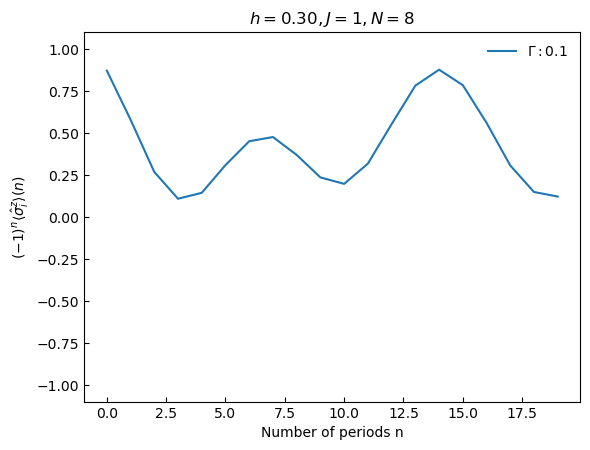

In [11]:
from ssl import Options
from scipy.special import jn_zeros
from itertools import combinations
import numpy as np
from qutip import *
from scipy import signal
import traceback
import tqdm
from multiprocessing import Pool
from scipy.linalg import expm
import matplotlib.pyplot as plt

def hamiltonians(args):
    N  =  args['N']
    J = args['J']
    Jvalue = args['J']
    beta = args['beta']
    gamma = args['gamma']
    h = args['h']
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)    
    H1, H2, H3 = empt,  empt, empt
    '''    
    for i in range(N-1):
        id = qeye(2**i)    
        dim11 = N-2-i
        id1 = qeye(2**dim11)
        H1 = H1 + Qobj(tensor(id, tensor(sz, tensor(sz, id1))).full())        
    H1 = H1 + Qobj(tensor(sz, tensor(qeye(2**(N-2)), sz)).full())
    '''
    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H1 = H1 + Qobj(tensor(id, tensor(sx, tensor(id1, tensor(sx,id2)))).full())\
            * j_ij(Jvalue, i,j, beta)

    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H2 = H2 + Qobj(tensor(id,tensor(sz,id1)).full()) 
                
    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H3 = H3 + Qobj(tensor(id,tensor(sx,id1)).full())

    H0 = H1/N + Qobj(h * H2.full())
    H1 = gamma * H3

    return H0, H1, H2, H3

def j_ij(Jvalue, i,j, beta):
    return Jvalue/(np.abs(i-j))**beta

def strobs_exps(args):
    N = args['N']
    nn = args['nn']    
    
    H0, H1, H2, H3 = hamiltonians(args)
    H_p = (H0 + H1).full()
    H_m = (H0 - H1).full() 
    H_pi = (np.pi/2 * H3).full()
    
    U_p = expm(-1j * H_p)
    U_n = expm(-1j * H_m)
    U_pi = expm(-1j *  H_pi)
    
    U  = U_pi @ U_n @ U_p
    #U  = U_p
    expValues = []
    psi = basis(2**N, 0).full()
    #psi = np.ones(2**N)/np.sqrt(N)
    
    identity_check = U.conj().T @ U
    print("Is U unitary?", np.allclose(identity_check, np.eye(identity_check.shape[0])))

    for i in range(nn):
        psi = U @ psi  # apply unitary
        expValue = np.real(np.vdot(psi, (-H2/N).full() @ psi))  # expectation value
        expValues.append(expValue)
        
    return expValues
    

N = 8
nn = 20  # Time period upto which stroboscopic evolution is computed
J = 1
h = 0.3
gammas = [0.1]

beta = float('inf')
#beta = 0

params = [{'N':N,'J':J,'maxT':nn, 'h':h, 'nn':nn, 'beta':beta, 'gamma':gamma} for gamma in gammas]

nprocs = len(gammas)
p = Pool(processes = nprocs) 
opts = Options(num_cpus=1, openmp_threads=1)

data_strob = np.array(p.map(strobs_exps, params))
    
order_param = np.array([(-1)**(i) for i in np.arange(nn)])
for idx, gamma in enumerate(gammas):
    plt.plot(np.arange(nn), order_param * data_strob[idx], label=fr"$\Gamma:{gamma}$")
    #plt.plot(np.arange(nn), expValues)

#plt.ylim(-1.1,1.1)
#for i in np.arange(0, nn, 2):
#    plt.axvline(x = i, color = 'blue', alpha = 0.3,ls ='--')


plt.xlabel('Number of periods n')
plt.ylabel(r'$(-1)^n\langle \hat{\sigma}^z_i \rangle(n)$')
plt.title(fr"$h={h:1.2f}, J={J},  N={N}$", fontsize = 12)
plt.tick_params(axis='both', which='both', labelsize=10)
plt.tick_params(which='both', direction='in')

plt.ylim(-1.1, 1.1)

plt.legend(frameon =False)
plt.show()

Different Ns

Is U unitary? True
Is U unitary? True
Is U unitary? True


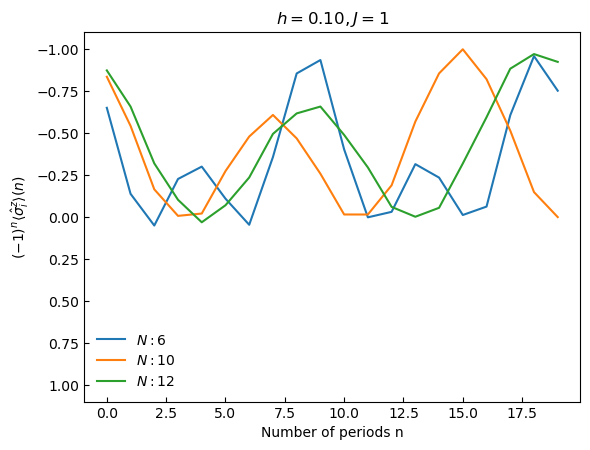

In [ ]:
from ssl import Options
from scipy.special import jn_zeros
from itertools import combinations
import numpy as np
from qutip import *
from scipy import signal
import traceback
import tqdm
from multiprocessing import Pool
from scipy.linalg import expm
import matplotlib.pyplot as plt

def hamiltonians(args):
    N  =  args['N']
    J = args['J']
    Jvalue = args['J']
    beta = args['beta']
    gamma = args['gamma']
    h = args['h']
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)    
    H1, H2, H3 = empt,  empt, empt
    '''    
    for i in range(N-1):
        id = qeye(2**i)    
        dim11 = N-2-i
        id1 = qeye(2**dim11)
        H1 = H1 + Qobj(tensor(id, tensor(sz, tensor(sz, id1))).full())        
    H1 = H1 + Qobj(tensor(sz, tensor(qeye(2**(N-2)), sz)).full())
    '''
    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H1 = H1 + Qobj(tensor(id, tensor(sx, tensor(id1, tensor(sx,id2)))).full())\
            * j_ij(Jvalue, i,j, beta)

    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H2 = H2 + Qobj(tensor(id,tensor(sz,id1)).full()) 
                
    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H3 = H3 + Qobj(tensor(id,tensor(sx,id1)).full())

    H0 = H1/N + Qobj(h * H2.full())
    H1 = gamma * H3

    return H0, H1, H2, H3

def j_ij(Jvalue, i,j, beta):
    return Jvalue/(np.abs(i-j))**beta

def strobs_exps(args):
    N = args['N']
    nn = args['nn']    
    
    H0, H1, H2, H3 = hamiltonians(args)
    H_p = (H0 + H1).full()
    H_m = (H0 - H1).full() 
    H_pi = (np.pi/2 * H3).full()
    
    U_p = expm(-1j * H_p)
    U_n = expm(-1j * H_m)
    U_pi = expm(-1j *  H_pi)
    
    U  = U_pi @ U_n @ U_p
    #U  = U_p
    expValues = []
    psi = basis(2**N, 0).full()
    #psi = np.ones(2**N)/np.sqrt(N)
    
    identity_check = U.conj().T @ U
    print("Is U unitary?", np.allclose(identity_check, np.eye(identity_check.shape[0])))

    for i in range(nn):
        psi = U @ psi  # apply unitary
        expValue = np.real(np.vdot(psi, (H2/N).full() @ psi))  # expectation value
        expValues.append(expValue)
        
    return expValues
    

Ns = [6, 10, 12]
nn = 20  
J = 1
h = 0.1
gamma = 0.8

beta = float('inf')
#beta = 0

params = [{'N':N,'J':J,'maxT':nn, 'h':h, 'nn':nn, 'beta':beta, 'gamma':gamma} for N in Ns]

nprocs = len(Ns)
p = Pool(processes = nprocs) 
opts = Options(num_cpus=1, openmp_threads=1)

data_strob = np.array(p.map(strobs_exps, params))
    
order_param = np.array([(-1)**(i) for i in np.arange(nn)])
for idx, N in enumerate(Ns):
    plt.plot(np.arange(nn), order_param * data_strob[idx], label=fr"$N:{N}$")
    #plt.plot(np.arange(nn), expValues)

#plt.ylim(-1.1,1.1)
#for i in np.arange(0, nn, 2):
#    plt.axvline(x = i, color = 'blue', alpha = 0.3,ls ='--')

plt.xlabel('Number of periods n')
plt.ylabel(r'$(-1)^n\langle \hat{\sigma}^z_i \rangle(n)$')
plt.title(fr"$h={h:1.2f}, J={J}$", fontsize = 12)
plt.tick_params(axis='both', which='both', labelsize=10)
plt.tick_params(which='both', direction='in')

#plt.ylim(-1.1, 1.1)

# ylim = -1.1 at top of the  y axis
plt.ylim(1.1, -1.1)

plt.legend(frameon =False)
plt.show()